#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

In [1]:
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse

In [3]:
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Подготовка

In [5]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
display(df.info())
print()
display(df.shape)
print()
display(df.index.is_monotonic_increasing)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

(26496, 1)

True

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Данные загружены, пропусков нет. Неявных дубликатов, как и явных, в этом датасете быть не может.

In [8]:
df = df.resample('1H').sum()

## Анализ

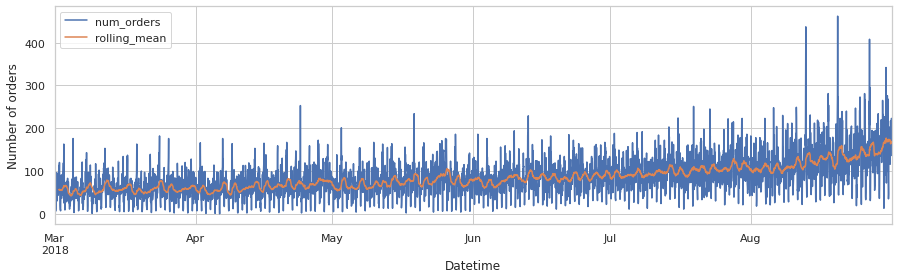

In [9]:
df_ = df.copy()
df_['rolling_mean'] = df_.rolling(24).mean()

plt.rcParams['figure.figsize'] = [15, 4]
sns.set(style='whitegrid')
df_.plot()
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.show()

Скользящее среднее со временем увеличивается. Можно предположить, что ряд нестационарен.

In [10]:
decomposed = seasonal_decompose(df)

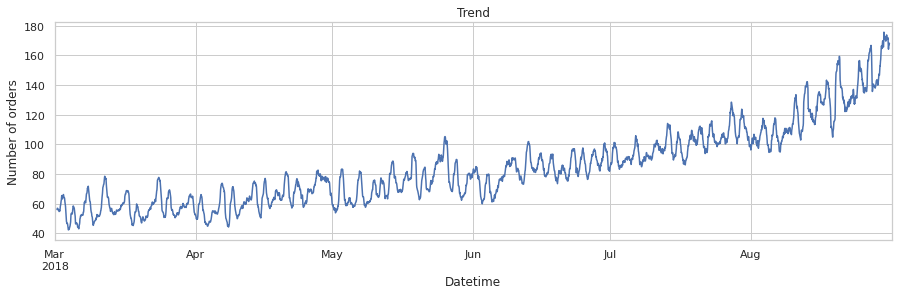

In [11]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.show()

Вижу тренд на увеличение числа заказов к концу летнего периода &mdash; началу осени.

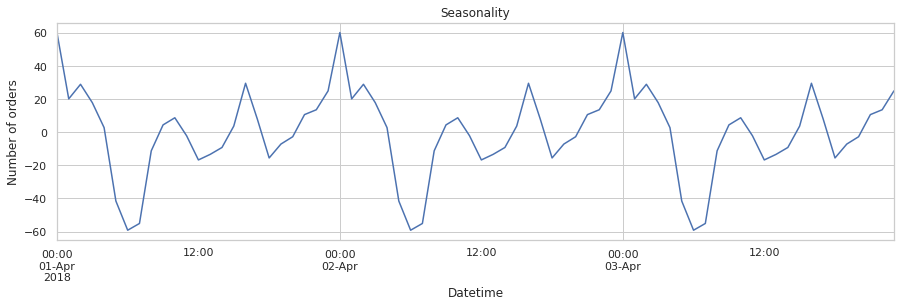

In [12]:
decomposed.seasonal['2018-04-01':'2018-04-3'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.show()

Сезонность дневная, спад заказов наблюдается к 6 утра, пик достигается к полуночи. Это связано со временем прибытия / отправления самолетов. Можно заключить, что к ночи прилетает / отправляется большее количество самолетов, нежели чем рано утром.

## Обучение

In [15]:
make_features(df, 20, 3)

В преобразованном датасете столбцы 'month', 'day', 'dayofweek' уже записаны таким образом, как если преобразовывать их OrdinalEncoder-ом, который и стоило бы использовать, если тип данных был другой. Надо отделить оставшиеся столбцы и скалировать их.

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

X_train, X_test = train.drop('num_orders', axis=1), test.drop('num_orders', axis=1)
y_train, y_test = train['num_orders'], test['num_orders']

X_train.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 20:00:00,1,3,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,54.000000
2018-03-01 21:00:00,1,3,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,59.666667
2018-03-01 22:00:00,1,3,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,57.333333
2018-03-01 23:00:00,1,3,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,80.000000
2018-03-02 00:00:00,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,79.000000


In [17]:
ord_columns = X_train.columns.to_list()[:3]
num_columns = X_train.columns.to_list()[3:]
ord_columns, num_columns

(['day', 'dayofweek', 'lag_1'],
 ['lag_2',
  'lag_3',
  'lag_4',
  'lag_5',
  'lag_6',
  'lag_7',
  'lag_8',
  'lag_9',
  'lag_10',
  'lag_11',
  'lag_12',
  'lag_13',
  'lag_14',
  'lag_15',
  'lag_16',
  'lag_17',
  'lag_18',
  'lag_19',
  'lag_20',
  'rolling_mean'])

In [18]:
X_train_ord = X_train[ord_columns]
X_test_ord = X_test[ord_columns]

In [19]:
scaler = MinMaxScaler()
scaler.fit(X_train[num_columns])
X_train_scaled = scaler.transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

df_scaled_train = pd.DataFrame(X_train_scaled, columns=num_columns, index=X_train.index)
df_scaled_test = pd.DataFrame(X_test_scaled, columns=num_columns, index=X_test.index)

In [20]:
X_train = pd.concat([X_train_ord, df_scaled_train], axis=1)
X_test = pd.concat([X_test_ord, df_scaled_test], axis=1)

X_train.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 20:00:00,1,3,45.0,0.167048,0.100686,0.098398,0.151030,0.109840,0.073227,0.068650,...,0.124542,0.059289,0.047431,0.023715,0.169960,0.260870,0.280632,0.335968,0.490119,0.175115
2018-03-01 21:00:00,1,3,61.0,0.102975,0.167048,0.100686,0.098398,0.151030,0.109840,0.073227,...,0.252747,0.134387,0.059289,0.047431,0.023715,0.169960,0.260870,0.280632,0.335968,0.194700
2018-03-01 22:00:00,1,3,66.0,0.139588,0.102975,0.167048,0.100686,0.098398,0.151030,0.109840,...,0.234432,0.272727,0.134387,0.059289,0.047431,0.023715,0.169960,0.260870,0.280632,0.186636
2018-03-01 23:00:00,1,3,113.0,0.151030,0.139588,0.102975,0.167048,0.100686,0.098398,0.151030,...,0.351648,0.252964,0.272727,0.134387,0.059289,0.047431,0.023715,0.169960,0.260870,0.264977
2018-03-02 00:00:00,2,4,58.0,0.258581,0.151030,0.139588,0.102975,0.167048,0.100686,0.098398,...,0.109890,0.379447,0.252964,0.272727,0.134387,0.059289,0.047431,0.023715,0.169960,0.261521


### DecisionTreeRegressor

In [21]:
warnings.filterwarnings('ignore')

model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

max_depth = range(1, 20)
min_samples_split = range(1, 10)
min_samples_leaf = range(1, 10)

tscv = TimeSeriesSplit(n_splits=5)

param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

randomized_search_dtr = RandomizedSearchCV(
    model_dtr,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [22]:
randomized_search_dtr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_dtr.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', -randomized_search_dtr.best_score_)

Лучшая модель и её параметры:

 DecisionTreeRegressor(max_depth=6, min_samples_leaf=7, min_samples_split=8,
                      random_state=42)
Метрика лучшей модели на тренировочной выборке: 33.582825969924485


### LGBMRegressor

In [23]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

num_leaves = range(1, 100, 2)
max_depth = range(1, 20)
n_estimators = range(1, 100, 2)

param_grid = dict(num_leaves=num_leaves, max_depth=max_depth, n_estimators=n_estimators)

randomized_search_lgbm = RandomizedSearchCV(
    model_lgbm,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_lgbm.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_lgbm.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', -randomized_search_lgbm.best_score_)

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



Лучшая модель и её параметры:

 LGBMRegressor(max_depth=9, n_estimators=79, num_leaves=25, random_state=42)
Метрика лучшей модели на тренировочной выборке: 28.174429829780923


Выберу моедль LGBMRegressor-а с измененными гиперпараметрами, она показала хорошую метрику.

## Тестирование

In [24]:
best_model = randomized_search_lgbm.best_estimator_
preds = best_model.predict(X_test)
RMSE = (mse(y_test, preds))**0.5
RMSE

47.27276166541239

Метрика RMSE меньше 48, что удовлетворяет требованиям заказчика.